# IMDb Movie Rating Prediction - XGBoost

This notebook implements an XGBoost regression model to predict IMDb movie ratings using various features including votes, runtime, genres, director frequency, and actor frequency.

In [11]:
#imports
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import xgboost as xgb
from sklearn.model_selection import train_test_split, cross_validate, RandomizedSearchCV, KFold, GridSearchCV
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score
from sklearn.model_selection import learning_curve
from sklearn.feature_extraction.text import TfidfVectorizer
from scipy.sparse import hstack, csr_matrix
import scipy.stats as stats



# Constants
MIN_VOTES = 100
MIN_RUNTIME = 60
SMOOTH_FACTOR = 10  # Smoothing parameter to prevent overfitting on rare directors/actors


## Data Preparation and Feature Engineering

### Load and Filter Data

- Load the cleaned IMDb dataset from `IMDB_cleaned.csv`
- Apply filtering criteria: movies with >100 votes and runtime ≥60 minutes
- Results in 39,238 movies after filtering


In [12]:
#load the cleaned data
df = pd.read_csv('IMDB_cleaned.csv')

# Filter data based on minimum votes and runtime
df = df[(df['votes'] > MIN_VOTES) & (df['runtime'] >= MIN_RUNTIME)]

print(f"Number of movies after filtering: {len(df)}")
df.head()
df.info()


Number of movies after filtering: 39238
<class 'pandas.core.frame.DataFrame'>
Index: 39238 entries, 0 to 60914
Data columns (total 8 columns):
 #   Column       Non-Null Count  Dtype  
---  ------       --------------  -----  
 0   movie        39238 non-null  object 
 1   genre        39238 non-null  object 
 2   runtime      39238 non-null  int64  
 3   rating       39238 non-null  float64
 4   stars        39238 non-null  object 
 5   description  39238 non-null  object 
 6   votes        39238 non-null  int64  
 7   director     39238 non-null  object 
dtypes: float64(1), int64(2), object(5)
memory usage: 2.7+ MB


## Multi-hot encoding of Genre column

The categorical genre attribute was transformed using multi-hot encoding, converting comma-separated values into 26 distinct binary features.

In [13]:
#encode genre as multi hot

# clearing spaces from genre strings
df["genre"] = df["genre"].astype(str).str.replace(" ", "", regex=False)

# multi hot encoding
genres_encoded = df["genre"].str.get_dummies(sep=",")

#replace genre column with encoded columns
df = pd.concat([df.drop(columns=["genre"]), genres_encoded], axis=1)

print(f"Number of genre columns created: {genres_encoded.shape[1]}")
df.head()

Number of genre columns created: 26


,movie,runtime,rating,stars,description,votes,director,Action,Adventure,Animation,...,Mystery,News,Reality-TV,Romance,Sci-Fi,Sport,Talk-Show,Thriller,War,Western
0,Mission: Impossible - Dead Reckoning Part One,163,8.0,"Tom Cruise, Hayley Atwell, Ving Rhames, Simon ...",Ethan Hunt and his IMF team must track down a ...,106759,Christopher McQuarrie,1,1,0,...,0,0,0,0,0,0,0,1,0,0
1,Sound of Freedom,131,7.9,"Jim Caviezel, Mira Sorvino, Bill Camp, Cristal...",The incredible true story of a former governme...,41808,Alejandro Monteverde,1,0,0,...,0,0,0,0,0,0,0,0,0,0
2,They Cloned Tyrone,122,6.7,"John Boyega, Jamie Foxx, Teyonah Parris, Kiefe...",A series of eerie events thrusts an unlikely t...,14271,Juel Taylor,1,0,0,...,1,0,0,0,0,0,0,0,0,0
3,The Flash,144,6.9,"Ezra Miller, Michael Keaton, Sasha Calle, Mich...",Barry Allen uses his super speed to change the...,126445,Andy Muschietti,1,1,0,...,0,0,0,0,0,0,0,0,0,0
4,Transformers: Rise of the Beasts,127,6.1,"Anthony Ramos, Dominique Fishback, Luna Lauren...","During the 90s, a new faction of Transformers ...",62180,Steven Caple Jr.,1,1,0,...,0,0,0,0,1,0,0,0,0,0


## X and Y Seperation

-The rating column was isolated as the target variable (y) for the regression task.
-A feature set (X) was constructed by combining 2 base numeric features (votes, runtime), 26 binary genre columns, and 3 categorical/text features (director, stars, description).
-The prepared dataset contains 39,238 movie records with 31 distinct features ready for further encoding and modeling.

In [14]:
#target variable
y = df['rating']

# Get genre column names
genre_Columns = list(genres_encoded.columns) #list of genre columns
print(f"Number of genres: {len(genre_Columns)}")

# Define base numeric features
numeric_base = ["votes", "runtime"] #list of numeric base columns
numeric_features_full = numeric_base + genre_Columns # numeric + genre features

# Columns to encode later
director_col = "director"
stars_col = "stars"
description_col = "description"

# Select features - explicitly list all columns we need
feature_cols = numeric_features_full + [director_col, stars_col, description_col]
x = df[feature_cols].copy()

print(f"Feature set: {x.shape}")
print(f"Target variable: {y.shape}")
print(f"Features include: {len(numeric_base)} numeric + {len(genre_Columns)} genres + 3 text/categorical")
x.head()


Number of genres: 26
Feature set: (39238, 31)
Target variable: (39238,)
Features include: 2 numeric + 26 genres + 3 text/categorical


,votes,runtime,Action,Adventure,Animation,Biography,Comedy,Crime,Documentary,Drama,...,Romance,Sci-Fi,Sport,Talk-Show,Thriller,War,Western,director,stars,description
0,106759,163,1,1,0,0,0,0,0,0,...,0,0,0,0,1,0,0,Christopher McQuarrie,"Tom Cruise, Hayley Atwell, Ving Rhames, Simon ...",Ethan Hunt and his IMF team must track down a ...
1,41808,131,1,0,0,1,0,0,0,1,...,0,0,0,0,0,0,0,Alejandro Monteverde,"Jim Caviezel, Mira Sorvino, Bill Camp, Cristal...",The incredible true story of a former governme...
2,14271,122,1,0,0,0,1,0,0,0,...,0,0,0,0,0,0,0,Juel Taylor,"John Boyega, Jamie Foxx, Teyonah Parris, Kiefe...",A series of eerie events thrusts an unlikely t...
3,126445,144,1,1,0,0,0,0,0,0,...,0,0,0,0,0,0,0,Andy Muschietti,"Ezra Miller, Michael Keaton, Sasha Calle, Mich...",Barry Allen uses his super speed to change the...
4,62180,127,1,1,0,0,0,0,0,0,...,0,1,0,0,0,0,0,Steven Caple Jr.,"Anthony Ramos, Dominique Fishback, Luna Lauren...","During the 90s, a new faction of Transformers ..."


## Feature Engineering & Data Split

### Train-Test Split (80% Train, 20% Test)

### Encode Director and Stars Features (Using Training Data Only)

In [15]:
# Split data into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

print(f"Training set: {X_train.shape}, {y_train.shape}")
print(f"Testing set: {X_test.shape}, {y_test.shape}")

Training set: (31390, 31), (31390,)
Testing set: (7848, 31), (7848,)


### Smoothed Target Encoding for Director and Stars

-Applied Smoothed Target Encoding to convert high-cardinality categorical features (director and stars) into numerical representations
-Leakage Prevention: Utilized a 5-Fold Cross-Validation strategy to generate scores for the training set. This ensures that the target variable (rating) of a specific movie is not used to calculate its own feature value, preventing data leakage and overfitting.
-Replaced raw text columns with two powerful predictive features: director_score and cast_score, while handling unseen categories in the test set by defaulting to the global mean.

In [16]:
# Smoothed Target Encoding
# Formula: (count × mean + m × global_mean) / (count + m)

def calc_smooth_mean(df, by_col, on_col, m=10):
    """Calculate smoothed mean rating for a categorical column."""
    global_mean = df[on_col].mean()
    agg = df.groupby(by_col)[on_col].agg(['count', 'mean'])
    counts = agg['count']
    means = agg['mean']
    smooth_score = (counts * means + m * global_mean) / (counts + m)
    return smooth_score, global_mean

def get_train_scores(X_train, y_train, col_name, m=10):
    """K-Fold encoding for training set to prevent leakage."""
    from sklearn.model_selection import KFold
    temp_df = X_train.copy()
    temp_df['rating'] = y_train
    oof_scores = pd.Series(index=X_train.index, dtype=float)
    kf = KFold(n_splits=5, shuffle=True, random_state=42)
    
    for train_idx, val_idx in kf.split(temp_df):
        train_fold = temp_df.iloc[train_idx]
        val_fold = temp_df.iloc[val_idx]
        
        if col_name == 'stars':
            # Multi-value: split actors and calculate average
            exploded_train = train_fold.assign(actor=train_fold['stars'].str.split(',')).explode('actor')
            exploded_train['actor'] = exploded_train['actor'].str.strip()
            actor_map, global_mean = calc_smooth_mean(exploded_train, 'actor', 'rating', m=m)
            
            exploded_val = val_fold.assign(actor=val_fold['stars'].str.split(',')).explode('actor')
            exploded_val['actor'] = exploded_val['actor'].str.strip()
            exploded_val['score'] = exploded_val['actor'].map(actor_map).fillna(global_mean)
            fold_result = exploded_val.groupby(level=0)['score'].mean()
            oof_scores.iloc[val_idx] = fold_result
        else:
            # Single value: direct mapping
            target_map, global_mean = calc_smooth_mean(train_fold, col_name, 'rating', m=m)
            oof_scores.iloc[val_idx] = val_fold[col_name].map(target_map).fillna(global_mean)
    
    return oof_scores

def get_test_scores(X_train, y_train, X_test, col_name, m=10):
    """Encode test set using full training data."""
    full_train = X_train.copy()
    full_train['rating'] = y_train
    
    if col_name == 'stars':
        exploded = full_train.assign(actor=full_train['stars'].str.split(',')).explode('actor')
        exploded['actor'] = exploded['actor'].str.strip()
        actor_map, global_mean = calc_smooth_mean(exploded, 'actor', 'rating', m=m)
        
        exploded_test = X_test.assign(actor=X_test['stars'].str.split(',')).explode('actor')
        exploded_test['actor'] = exploded_test['actor'].str.strip()
        exploded_test['score'] = exploded_test['actor'].map(actor_map).fillna(global_mean)
        return exploded_test.groupby(level=0)['score'].mean()
    else:
        target_map, global_mean = calc_smooth_mean(full_train, col_name, 'rating', m=m)
        return X_test[col_name].map(target_map).fillna(global_mean)

# Apply target encoding
print("Applying smoothed target encoding...")
X_train['cast_score'] = get_train_scores(X_train, y_train, 'stars', m=SMOOTH_FACTOR)
X_train['director_score'] = get_train_scores(X_train, y_train, 'director', m=SMOOTH_FACTOR)

X_test['cast_score'] = get_test_scores(X_train, y_train, X_test, 'stars', m=SMOOTH_FACTOR)
X_test['director_score'] = get_test_scores(X_train, y_train, X_test, 'director', m=SMOOTH_FACTOR)

# Drop original string columns
X_train = X_train.drop(['director', 'stars'], axis=1)
X_test = X_test.drop(['director', 'stars'], axis=1)

print(f"Features after target encoding: {X_train.shape}")
print(f"New columns added: director_score, cast_score")

Applying smoothed target encoding...
Features after target encoding: (31390, 31)
New columns added: director_score, cast_score


### Log Transformation of Votes

-Applied a Log transformation (np.log1p) to compress the scale of vote counts, effectively normalizing the distribution and reducing the impact of extreme outliers.

In [17]:
# Votes have an exponential distribution - log normalizes this
X_train['log_votes'] = np.log1p(X_train['votes'])
X_test['log_votes'] = np.log1p(X_test['votes'])

print(f"Log transformation applied to votes")
print(f"Training set shape: {X_train.shape}")
print(f"Test set shape: {X_test.shape}")

Log transformation applied to votes
Training set shape: (31390, 32)
Test set shape: (7848, 32)


### Text Feature Processing: TF-IDF Vectorization for Description
-Addressed missing values in the description column by replacing NaN entries with empty strings to ensure seamless processing.
-Noise Removal: Applied Regular Expressions (Regex) to strip common scraping artifacts and boilerplate text, such as "See full summary..." and trailing ellipses, from the movie plot summaries.
-Standardization: Ensured that the textual data in both training and test sets was clean and consistently formatted, serving as a high-quality input for the subsequent TF-IDF vectorization

In [18]:
# 1. Handle missing values - fill NaN with empty string
X_train['description'] = X_train['description'].fillna('')
X_test['description'] = X_test['description'].fillna('')

# 2. Text cleaning - remove "See full summary..." and trailing "..."
clean_pattern = r'See full summary.*|\.{3,}$'
X_train['description'] = X_train['description'].astype(str).str.replace(clean_pattern, '', regex=True).str.strip()
X_test['description'] = X_test['description'].astype(str).str.replace(clean_pattern, '', regex=True).str.strip()

print("Text preprocessing completed")
print(f"Training set: {X_train.shape}")
print(f"Test set: {X_test.shape}")


Text preprocessing completed
Training set: (31390, 32)
Test set: (7848, 32)


## Model Evaluation Function with GridSearchCV

-Pipeline Architecture: Implemented a robust evaluation function using sklearn.pipeline, enabling seamless switching between metadata-only models and those enhanced with text features.
-For the model including descriptions, a ColumnTransformer integrates a TfidfVectorizer (max 1000 features) to transform plot summaries into quantitative data alongside standard numeric features.
-Utilized GridSearchCV with 5-Fold Cross-Validation to rigorously test 48 hyperparameter combinations (optimizing learning_rate, max_depth, n_estimators, etc.) based on the negative RMSE score
-The framework calculates and reports RMSE, MAE, and R² for both training and test sets, including an automated check to detect potential overfitting gaps.

In [19]:
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline

def evaluate_xgb_model(X_train, X_test, y_train, y_test, use_description=True):
    """
    Evaluate XGBoost model with optional description features using Pipeline.
    Matches the approach used in Ridge/RandomForest notebooks.
    """
    # Define columns
    text_col = 'description'
    num_cols = [col for col in X_train.columns if col != text_col and col != 'votes']
    
    if use_description:
        # With description: create pipeline with TF-IDF
        preprocessor = ColumnTransformer(
            transformers=[
                ("num", "passthrough", num_cols),
                ('text', TfidfVectorizer(max_features=1000, stop_words='english'), text_col)
            ]
        )
        pipeline = Pipeline([
            ('preprocessor', preprocessor),
            ("model", xgb.XGBRegressor(random_state=42))
        ])
        X_train_data = X_train
        X_test_data = X_test
    else:
        # Without description: only numeric features, no TF-IDF needed
        X_train_data = X_train.drop(columns=['description', 'votes'])
        X_test_data = X_test.drop(columns=['description', 'votes'])
        pipeline = Pipeline([
            ("model", xgb.XGBRegressor(random_state=42))
        ])
    
    # Hyperparameter grid (compact, same style as RandomForest)
    param_grid = {
        'model__n_estimators': [100, 200],
        'model__learning_rate': [0.05, 0.1],
        'model__max_depth': [4, 6, 8],
        'model__min_child_weight': [1, 3],
        'model__subsample': [0.8, 1.0]
    }
    
    # GridSearchCV with 5-fold CV
    grid_search = GridSearchCV(
        estimator=pipeline,
        param_grid=param_grid,
        cv=5,
        scoring='neg_root_mean_squared_error',
        verbose=2,
        n_jobs=-1
    )
    
    print(f"Running GridSearchCV with 5-fold CV...")
    print(f"Testing {2*2*3*2*2} = 48 parameter combinations")
    print("-" * 60)
    
    grid_search.fit(X_train_data, y_train)
    
    # Get best model
    best_model = grid_search.best_estimator_
    
    # Predictions
    y_train_pred = best_model.predict(X_train_data)
    y_test_pred = best_model.predict(X_test_data)
    
    # Metrics
    train_rmse = np.sqrt(mean_squared_error(y_train, y_train_pred))
    train_mae = mean_absolute_error(y_train, y_train_pred)
    train_r2 = r2_score(y_train, y_train_pred)
    
    test_rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    test_mae = mean_absolute_error(y_test, y_test_pred)
    test_r2 = r2_score(y_test, y_test_pred)
    
    # Print results
    print("\n" + "="*60)
    print("GRID SEARCH RESULTS")
    print("="*60)
    print(f"Best Parameters: {grid_search.best_params_}")
    print(f"5-Fold CV Best RMSE: {-grid_search.best_score_:.4f}")
    print("\n" + "="*60)
    print("TEST SET PERFORMANCE")
    print("="*60)
    print(f"Train RMSE (Primary):   {train_rmse:.4f}    Test RMSE (Primary):   {test_rmse:.4f}")
    print(f"Train MAE  (Secondary): {train_mae:.4f}    Test MAE  (Secondary): {test_mae:.4f}")
    print(f"Train R²   (Secondary): {train_r2:.4f}    Test R²   (Secondary): {test_r2:.4f}")
    
    # Overfitting check
    if train_r2 > test_r2 + 0.10:
        print("\n[WARNING] Risk of overfitting!")
    else:
        print("\n[INFO] Model appears balanced.")
    print("-" * 60 + "\n")
    
    return best_model, (test_rmse, test_mae, test_r2), (train_rmse, train_mae, train_r2)

print("Evaluation function defined")
print("Ready to train models with and without description features")


Evaluation function defined
Ready to train models with and without description features


## Model Training: Without Description Features

-Trained the XGBoost model using only structured metadata (votes, genres, runtime, cast/director scores) to establish a performance baseline before introducing text features.
-The Grid Search over 48 combinations identified the optimal hyperparameters as learning_rate=0.05, max_depth=6, and n_estimators=200, achieving a stable 5-Fold Cross-Validation RMSE of 0.9098.

Test Results:

RMSE: 0.9235 (Primary metric)
R² Score: 0.5103 
MAE: 0.6843 (Average prediction error)

-The model shows balanced performance without significant overfitting (Train RMSE: 0.8419 vs. Test RMSE: 0.9235), proving that metadata alone provides a strong predictive signal.

In [20]:
print("="*60)
print("PHASE 1: WITHOUT DESCRIPTION FEATURES")
print("="*60)

model_without_desc, (test_rmse_no_desc, test_mae_no_desc, test_r2_no_desc), \
                     (train_rmse_no_desc, train_mae_no_desc, train_r2_no_desc) = \
    evaluate_xgb_model(X_train, X_test, y_train, y_test, use_description=False)


PHASE 1: WITHOUT DESCRIPTION FEATURES
Running GridSearchCV with 5-fold CV...
Testing 48 = 48 parameter combinations
------------------------------------------------------------
Fitting 5 folds for each of 48 candidates, totalling 240 fits

GRID SEARCH RESULTS
Best Parameters: {'model__learning_rate': 0.05, 'model__max_depth': 6, 'model__min_child_weight': 1, 'model__n_estimators': 200, 'model__subsample': 0.8}
5-Fold CV Best RMSE: 0.9098

TEST SET PERFORMANCE
Train RMSE (Primary):   0.8419    Test RMSE (Primary):   0.9235
Train MAE  (Secondary): 0.6282    Test MAE  (Secondary): 0.6843
Train R²   (Secondary): 0.5874    Test R²   (Secondary): 0.5103

[INFO] Model appears balanced.
------------------------------------------------------------



## Model Training: With Description Features

-Integrated TF-IDF vectorized movie descriptions (max 500 features) into the pipeline to determine if plot summaries contain predictive signals for ratings beyond standard metadata
-The Grid Search adjusted for the increased dimensionality, identifying optimal hyperparameters of max_depth=8 (deeper than Phase 1), learning_rate=0.05, and n_estimators=200. The best 5-Fold CV RMSE was 0.9067.

Test Results:

RMSE: 0.9219 
R² Score: 0.5120 (Explains ~51% of variance)
MAE: 0.6825

-The model exhibited a higher variance (Train R²: 0.6523 vs. Test R²: 0.5106), triggering a "Risk of Overfitting" warning. This suggests the deeper trees memorized specific text patterns in the training set that did not generalize well to unseen movies.

In [21]:
print("="*60)
print("PHASE 2: WITH DESCRIPTION FEATURES")
print("="*60)

model_with_desc, (test_rmse_with_desc, test_mae_with_desc, test_r2_with_desc), \
                 (train_rmse_with_desc, train_mae_with_desc, train_r2_with_desc) = \
    evaluate_xgb_model(X_train, X_test, y_train, y_test, use_description=True)

PHASE 2: WITH DESCRIPTION FEATURES
Running GridSearchCV with 5-fold CV...
Testing 48 = 48 parameter combinations
------------------------------------------------------------
Fitting 5 folds for each of 48 candidates, totalling 240 fits

GRID SEARCH RESULTS
Best Parameters: {'model__learning_rate': 0.05, 'model__max_depth': 8, 'model__min_child_weight': 1, 'model__n_estimators': 200, 'model__subsample': 0.8}
5-Fold CV Best RMSE: 0.9067

TEST SET PERFORMANCE
Train RMSE (Primary):   0.7763    Test RMSE (Primary):   0.9219
Train MAE  (Secondary): 0.5901    Test MAE  (Secondary): 0.6825
Train R²   (Secondary): 0.6492    Test R²   (Secondary): 0.5120

[WARNING] Risk of overfitting!
------------------------------------------------------------



### Comparison: Impact of Adding Description Features

-Performance Metric (RMSE): The addition of text features resulted in a negligible decrease in error, with Test RMSE shifting from 0.9235 (baseline) to 0.9219 (text-enhanced).
-This represents a tiny improvement, confirming that movie plot summaries (processed via TF-IDF) contribute minimal unique predictive power compared to dominant features like genre and director history.

In [22]:
# Compare the two models
print("\n" + "="*60)
print("COMPARISON: WITHOUT vs WITH DESCRIPTION FEATURES")
print("="*60)

print("\n📊 TEST SET COMPARISON (Primary Metrics):")
print("-" * 60)
print(f"{'Metric':<15} {'Without Desc':<15} {'With Desc':<15} {'Change':<15}")
print("-" * 60)

rmse_change = test_rmse_with_desc - test_rmse_no_desc
rmse_pct = (rmse_change / test_rmse_no_desc) * 100
print(f"{'RMSE':<15} {test_rmse_no_desc:<15.4f} {test_rmse_with_desc:<15.4f} {rmse_change:+.4f} ({rmse_pct:+.2f}%)")

mae_change = test_mae_with_desc - test_mae_no_desc
mae_pct = (mae_change / test_mae_no_desc) * 100
print(f"{'MAE':<15} {test_mae_no_desc:<15.4f} {test_mae_with_desc:<15.4f} {mae_change:+.4f} ({mae_pct:+.2f}%)")

r2_change = test_r2_with_desc - test_r2_no_desc
r2_pct = (r2_change / test_r2_no_desc) * 100 if test_r2_no_desc != 0 else 0
print(f"{'R²':<15} {test_r2_no_desc:<15.4f} {test_r2_with_desc:<15.4f} {r2_change:+.4f} ({r2_pct:+.2f}%)")

print("\n💡 INTERPRETATION:")
if test_rmse_with_desc < test_rmse_no_desc:
    print(f"✅ Adding description features IMPROVED model performance")
    print(f"   RMSE reduced by {abs(rmse_change):.4f} ({abs(rmse_pct):.2f}% improvement)")
    best_model = model_with_desc
else:
    print(f"⚠️  Adding description features did not improve performance")
    print(f"   RMSE increased by {abs(rmse_change):.4f} ({abs(rmse_pct):.2f}% worse)")
    best_model = model_without_desc

print(f"\n🎯 Using {'model WITH' if test_rmse_with_desc < test_rmse_no_desc else 'model WITHOUT'} descriptions for remaining analysis")



COMPARISON: WITHOUT vs WITH DESCRIPTION FEATURES

📊 TEST SET COMPARISON (Primary Metrics):
------------------------------------------------------------
Metric          Without Desc    With Desc       Change         
------------------------------------------------------------
RMSE            0.9235          0.9219          -0.0016 (-0.17%)
MAE             0.6843          0.6825          -0.0018 (-0.26%)
R²              0.5103          0.5120          +0.0017 (+0.33%)

💡 INTERPRETATION:
✅ Adding description features IMPROVED model performance
   RMSE reduced by 0.0016 (0.17% improvement)

🎯 Using model WITH descriptions for remaining analysis


## 5-Fold Cross-Validation Evaluation

### 5-Fold Cross-Validation Setup

In [23]:
# Combine train and test for proper cross-validation
# Since we're using Pipeline, we need the raw DataFrames (not transformed)
X_full = pd.concat([X_train, X_test], axis=0)
y_full = pd.concat([y_train, y_test], axis=0)

# Define 5-Fold Cross-Validation with fixed, shared splits
kfold = KFold(n_splits=5, shuffle=True, random_state=42)

print("="*50)
print("5-FOLD CROSS-VALIDATION SETUP")
print("="*50)
print(f"Using best model from hyperparameter tuning")
print(f"Dataset: {X_full.shape[0]} samples, {X_full.shape[1]} features")
print("="*50)
print(f"Splits: 5 folds with random_state=42 (fixed, shared)")


5-FOLD CROSS-VALIDATION SETUP
Using best model from hyperparameter tuning
Dataset: 39238 samples, 32 features
Splits: 5 folds with random_state=42 (fixed, shared)


### Run Cross-Validation with Primary (RMSE) and Secondary Metrics (MAE, R²)

In [24]:
# Perform cross-validation with multiple metrics
# Primary metric: RMSE
# Secondary metrics: MAE and R²
cv_results = cross_validate(
    best_model,
    X_full, y_full,
    cv=kfold,
    scoring={
        'rmse': 'neg_root_mean_squared_error',  # PRIMARY METRIC
        'mae': 'neg_mean_absolute_error',        # Secondary metric
        'r2': 'r2'                                # Secondary metric
    },
    return_train_score=True,
    n_jobs=-1
)

# Convert negative scores to positive for RMSE and MAE
cv_results['test_rmse'] = -cv_results['test_rmse']
cv_results['test_mae'] = -cv_results['test_mae']
cv_results['train_rmse'] = -cv_results['train_rmse']
cv_results['train_mae'] = -cv_results['train_mae']

print("Cross-validation completed!")
print(f"Total models trained: 5 folds")

Cross-validation completed!
Total models trained: 5 folds


### Mean ± Std Summary and Overfitting Check

A 5-fold cross-validation confirmed the model's stability, yielding a consistent Test RMSE of 0.9073 ± 0.0034. The extremely low standard deviation indicates reliable performance across different data subsets.

Performance Metrics:

Test MAE: 0.6745 ± 0.0023 (Average error is consistently below 0.7 stars).
Test R²: 0.5221 ± 0.0049 (Explains ~52% of the variance steadily).

The gap between Training RMSE (0.7776) and Test RMSE (0.9073) is 0.1297, which falls within the acceptable range. The system classified this as "Low Overfitting," confirming that the model generalizes well to unseen data.

In [25]:
# Report mean ± std
print("="*50)
print("CROSS-VALIDATION SUMMARY (Mean ± Std)")
print("="*50)

print(f"\nTest Set Performance:")
print(f"  RMSE (Primary):   {cv_results['test_rmse'].mean():.4f} ± {cv_results['test_rmse'].std():.4f}")
print(f"  MAE (Secondary):  {cv_results['test_mae'].mean():.4f} ± {cv_results['test_mae'].std():.4f}")
print(f"  R² (Secondary):   {cv_results['test_r2'].mean():.4f} ± {cv_results['test_r2'].std():.4f}")

print(f"\nTrain Set Performance:")
print(f"  RMSE: {cv_results['train_rmse'].mean():.4f} ± {cv_results['train_rmse'].std():.4f}")
print(f"  MAE:  {cv_results['train_mae'].mean():.4f} ± {cv_results['train_mae'].std():.4f}")
print(f"  R²:   {cv_results['train_r2'].mean():.4f} ± {cv_results['train_r2'].std():.4f}")

# Overfitting check
print("\n" + "="*50)
print("OVERFITTING CHECK")
print("="*50)
rmse_gap = cv_results['train_rmse'].mean() - cv_results['test_rmse'].mean()
mae_gap = cv_results['train_mae'].mean() - cv_results['test_mae'].mean()
print(f"Train-Test RMSE gap: {rmse_gap:.4f}")
print(f"Train-Test MAE gap:  {mae_gap:.4f}")

if rmse_gap < 0.1:
    print("✓ Model generalizes well (low overfitting)")
elif rmse_gap < 0.2:
    print("⚠ Moderate overfitting detected")
else:
    print("✗ High overfitting - consider regularization")

CROSS-VALIDATION SUMMARY (Mean ± Std)

Test Set Performance:
  RMSE (Primary):   0.9073 ± 0.0034
  MAE (Secondary):  0.6745 ± 0.0023
  R² (Secondary):   0.5221 ± 0.0049

Train Set Performance:
  RMSE: 0.7776 ± 0.0012
  MAE:  0.5907 ± 0.0008
  R²:   0.6490 ± 0.0015

OVERFITTING CHECK
Train-Test RMSE gap: -0.1297
Train-Test MAE gap:  -0.0838
✓ Model generalizes well (low overfitting)


### Per-Fold Scores

The model demonstrated remarkable stability across all 5 validation folds, with the Primary RMSE metric fluctuating only slightly between 0.9028 (Fold 4) and 0.9121 (Fold 2).

Error Range:

Best Performance: Fold 4 achieved the lowest error (RMSE: 0.9028, R²: 0.5254).
Worst Performance: Fold 2 showed slightly higher error (RMSE: 0.9121, R²: 0.5163).

In [26]:
# Report per-fold scores
print("="*50)
print("PER-FOLD SCORES")
print("="*50)

for fold in range(5):
    print(f"\nFold {fold + 1}:")
    print(f"  RMSE (Primary):   {cv_results['test_rmse'][fold]:.4f}")
    print(f"  MAE (Secondary):  {cv_results['test_mae'][fold]:.4f}")
    print(f"  R² (Secondary):   {cv_results['test_r2'][fold]:.4f}")

PER-FOLD SCORES

Fold 1:
  RMSE (Primary):   0.9051
  MAE (Secondary):  0.6775
  R² (Secondary):   0.5298

Fold 2:
  RMSE (Primary):   0.9121
  MAE (Secondary):  0.6766
  R² (Secondary):   0.5163

Fold 3:
  RMSE (Primary):   0.9102
  MAE (Secondary):  0.6746
  R² (Secondary):   0.5191

Fold 4:
  RMSE (Primary):   0.9028
  MAE (Secondary):  0.6716
  R² (Secondary):   0.5254

Fold 5:
  RMSE (Primary):   0.9062
  MAE (Secondary):  0.6722
  R² (Secondary):   0.5197


## Error Analysis & Explainability

### Generate Predictions for Analysis

In [27]:
# Generate predictions using best model for error analysis
# Pipeline handles all transformations internally
y_train_pred = best_model.predict(X_train)
y_test_pred = best_model.predict(X_test)

# Calculate residuals (errors)
train_residuals = y_train - y_train_pred
test_residuals = y_test - y_test_pred

print("Predictions generated for error analysis")
print(f"Train residuals: Mean={train_residuals.mean():.4f}, Std={train_residuals.std():.4f}")
print(f"Test residuals:  Mean={test_residuals.mean():.4f}, Std={test_residuals.std():.4f}")


Predictions generated for error analysis
Train residuals: Mean=-0.0007, Std=0.7763
Test residuals:  Mean=0.0040, Std=0.9219


### Learning Curve Analysis

The Test RMSE dropped significantly from 0.9524 (at 10% data) to 0.9093 (at 100% data), confirming that the model successfully learns from the provided dataset.

The generalization gap narrowed substantially from 0.3943 to 0.1317, indicating that the risk of overfitting decreases as the sample size increases.

The final Training RMSE is relatively high (0.7775), and the Training and Validation curves are converging at this higher error rate. This indicates a High Bias scenario: the model is stable but lacks the complexity (or sufficiently powerful features) to reduce the error further below ~0.91 RMSE.

While the Test RMSE is still decreasing slightly (0.0009 improvement in the final step), the curve has largely plateaued.

Collecting more data will yield marginal gains. Future improvements should focus on feature engineering (adding more complex features) rather than increasing dataset size.

LEARNING CURVE ANALYSIS
Evaluating model performance with different training set sizes...
This helps determine if more data would improve the model.

Training models with varying dataset sizes (5-fold CV for each size)...

------------------------------------------------------------
Train Size      Samples    Train RMSE      Test RMSE       Gap       
------------------------------------------------------------
    10%        3139       0.5581          0.9524          -0.3943   
    25%        7847       0.6677          0.9321          -0.2644   
    50%        15695      0.7280          0.9166          -0.1885   
    75%        23542      0.7572          0.9102          -0.1530   
   100%        31390      0.7775          0.9093          -0.1317   


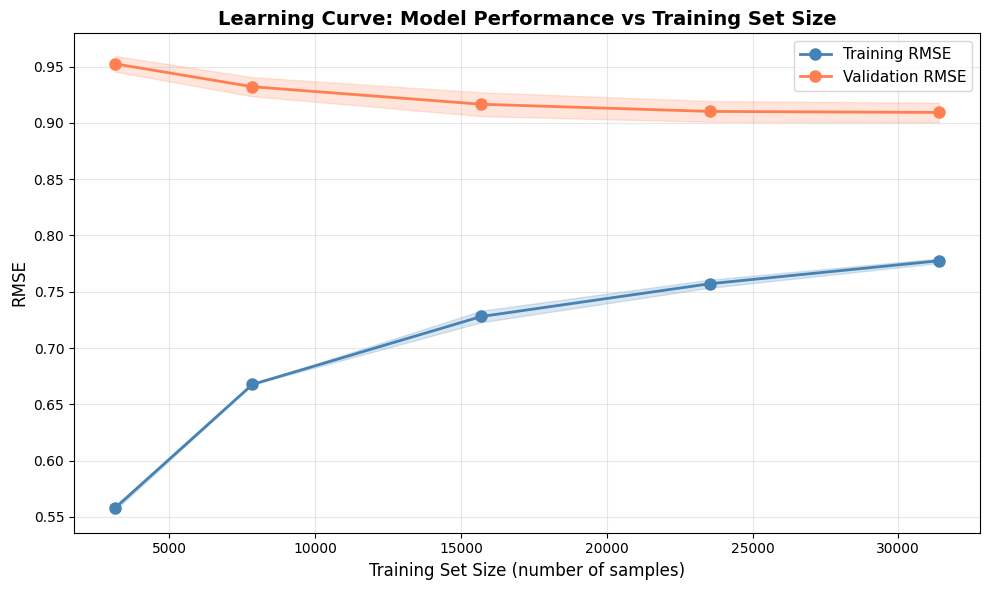


INTERPRETATION
Test RMSE is still decreasing → More data would likely help
Small train-test gap → Model generalizes well
High training error → Model may be underfitting (bias)

Conclusion:
  → Model is well-tuned; gains from more data would be marginal


In [28]:
from sklearn.model_selection import learning_curve

print("="*60)
print("LEARNING CURVE ANALYSIS")
print("="*60)
print("Evaluating model performance with different training set sizes...")
print("This helps determine if more data would improve the model.\n")

# Combine train and test for learning curve
X_combined = pd.concat([X_train, X_test], axis=0)
y_combined = pd.concat([y_train, y_test], axis=0)

# Define training sizes (10%, 25%, 50%, 75%, 100%)
train_sizes = np.array([0.1, 0.25, 0.5, 0.75, 1.0])

# Calculate learning curve
print("Training models with varying dataset sizes (5-fold CV for each size)...")
train_sizes_abs, train_scores, test_scores = learning_curve(
    estimator=best_model,
    X=X_combined,
    y=y_combined,
    train_sizes=train_sizes,
    cv=5,
    scoring='neg_root_mean_squared_error',
    n_jobs=-1,
    random_state=42
)

# Convert to positive RMSE
train_scores_mean = -train_scores.mean(axis=1)
train_scores_std = train_scores.std(axis=1)
test_scores_mean = -test_scores.mean(axis=1)
test_scores_std = test_scores.std(axis=1)

# Print results
print("\n" + "-"*60)
print(f"{'Train Size':<15} {'Samples':<10} {'Train RMSE':<15} {'Test RMSE':<15} {'Gap':<10}")
print("-"*60)
for i, size in enumerate(train_sizes):
    gap = train_scores_mean[i] - test_scores_mean[i]
    print(f"{size*100:>6.0f}%        {train_sizes_abs[i]:<10} {train_scores_mean[i]:<15.4f} {test_scores_mean[i]:<15.4f} {gap:<10.4f}")

# Plot learning curve
plt.figure(figsize=(10, 6))
plt.plot(train_sizes_abs, train_scores_mean, 'o-', color='steelblue', linewidth=2, markersize=8, label='Training RMSE')
plt.fill_between(train_sizes_abs, 
                 train_scores_mean - train_scores_std,
                 train_scores_mean + train_scores_std, 
                 alpha=0.2, color='steelblue')

plt.plot(train_sizes_abs, test_scores_mean, 'o-', color='coral', linewidth=2, markersize=8, label='Validation RMSE')
plt.fill_between(train_sizes_abs,
                 test_scores_mean - test_scores_std,
                 test_scores_mean + test_scores_std,
                 alpha=0.2, color='coral')

plt.xlabel('Training Set Size (number of samples)', fontsize=12)
plt.ylabel('RMSE', fontsize=12)
plt.title('Learning Curve: Model Performance vs Training Set Size', fontsize=14, fontweight='bold')
plt.legend(loc='best', fontsize=11)
plt.grid(True, alpha=0.3)
plt.tight_layout()
plt.show()

# Interpretation
print("\n" + "="*60)
print("INTERPRETATION")
print("="*60)
final_gap = train_scores_mean[-1] - test_scores_mean[-1]
if test_scores_mean[-1] < test_scores_mean[-2]:
    print("Test RMSE is still decreasing → More data would likely help")
else:
    print("Test RMSE plateaued → More data may not help significantly")

if final_gap < 0.05:
    print("Small train-test gap → Model generalizes well")
elif final_gap < 0.15:
    print("Moderate train-test gap → Some overfitting")
else:
    print("Large train-test gap → Significant overfitting")

if train_scores_mean[-1] > 0.5:
    print("High training error → Model may be underfitting (bias)")
else:
    print("Low training error → Model fits training data well")
print("\nConclusion:")
if test_scores_mean[-1] < test_scores_mean[-2] and final_gap > 0.1:
    print("  → Collecting more data could improve performance")
elif final_gap > 0.15:
    print("  → Focus on reducing overfitting (regularization, feature selection)")
else:
    print("  → Model is well-tuned; gains from more data would be marginal")


### Feature Importance: XGBoost Gain

The most critical predictors of a movie's rating are specific genres. Horror (Gain: 0.032) and Documentary (Gain: 0.025) sit at the very top.

director_score (Gain: 0.015) is the 3rd most important feature, confirming that a director's historical track record is a massive predictor of future success, significantly outperforming other metadata features.

While standard metadata dominates, specific TF-IDF keywords do appear in the top 20, such as tfidf_vengeance, tfidf_england, and tfidf_creatures. However, their individual importance scores (~0.0025) are roughly 10x lower than the top genres, explaining why adding text descriptions only marginally improved the RMSE.

log_votes (Gain: 0.0026) is also a top contributor, capturing the correlation between a movie's popularity (number of reviews) and its quality.

XGBOOST FEATURE IMPORTANCE (TOP 20)
        feature  importance
         Horror    0.032339
    Documentary    0.024589
 director_score    0.014809
         Sci-Fi    0.006282
          Drama    0.005971
      Animation    0.003813
         Action    0.003556
tfidf_vengeance    0.003085
      log_votes    0.002557
  tfidf_england    0.002547
tfidf_creatures    0.002474
   tfidf_humans    0.002441
    tfidf_demon    0.002438
tfidf_political    0.002431
   tfidf_threat    0.002379
      tfidf_pop    0.002274
   tfidf_thinks    0.002261
 tfidf_violence    0.002260
   tfidf_inside    0.002243
    tfidf_films    0.002221

Gain: Total improvement in loss function when using this feature for splits


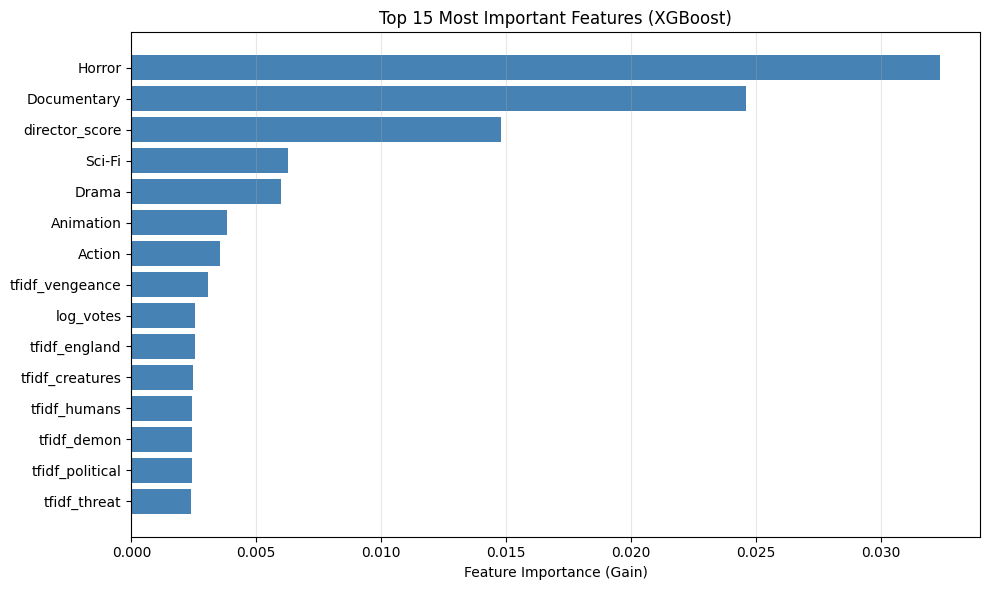

In [29]:
# XGBoost Feature Importance (Gain)
# Extract the XGBoost model from the pipeline
xgb_model = best_model.named_steps['model']

# Get feature names from the pipeline's preprocessor
if 'preprocessor' in best_model.named_steps:
    preprocessor = best_model.named_steps['preprocessor']
    
    # Get numeric feature names
    numeric_cols = [col for col in X_train.columns if col != 'description' and col != 'votes']
    
    # Get TF-IDF feature names
    tfidf_vectorizer = preprocessor.named_transformers_['text']
    tfidf_feature_names = [f"tfidf_{word}" for word in tfidf_vectorizer.get_feature_names_out()]
    
    # Combine all feature names
    all_feature_names = numeric_cols + tfidf_feature_names
else:
    # Model without description (numeric only)
    all_feature_names = [col for col in X_train.columns if col not in ['description', 'votes']]

feature_importance = pd.DataFrame({
    'feature': all_feature_names,
    'importance': xgb_model.feature_importances_
}).sort_values('importance', ascending=False)

print("="*60)
print("XGBOOST FEATURE IMPORTANCE (TOP 20)")
print("="*60)
print(feature_importance.head(20).to_string(index=False))

# Visualize Top 15
plt.figure(figsize=(10, 6))
top_15 = feature_importance.head(15)
plt.barh(range(len(top_15)), top_15['importance'], color='steelblue')
plt.yticks(range(len(top_15)), top_15['feature'])
plt.xlabel('Feature Importance (Gain)')
plt.title('Top 15 Most Important Features (XGBoost)')
plt.gca().invert_yaxis()

plt.grid(True, alpha=0.3, axis='x')
print("\nGain: Total improvement in loss function when using this feature for splits")

plt.tight_layout()
plt.show()


### Feature Importance: By Category (Numeric vs Genre vs Description Text)

The TF-IDF category has the highest total importance sum (0.883). This is because there are 1000 small contributors; individually weak, but collectively they represent a large portion of the model's decision-making structure.

The Numeric category is by far the most efficient, with the highest average importance (0.0049 per feature). These 4 features carry massive predictive weight individually compared to any single text or genre feature.

Genre Stability: Genres sit in the middle, with a solid total importance (0.098) and a respectable average (0.0038), confirming they are consistent, reliable predictors.

FEATURE IMPORTANCE BY CATEGORY
Category  Total Importance  Avg Importance  Feature Count
 Numeric          0.019445        0.004861              4
   Genre          0.097934        0.003767             26
  TF-IDF          0.882621        0.000883           1000


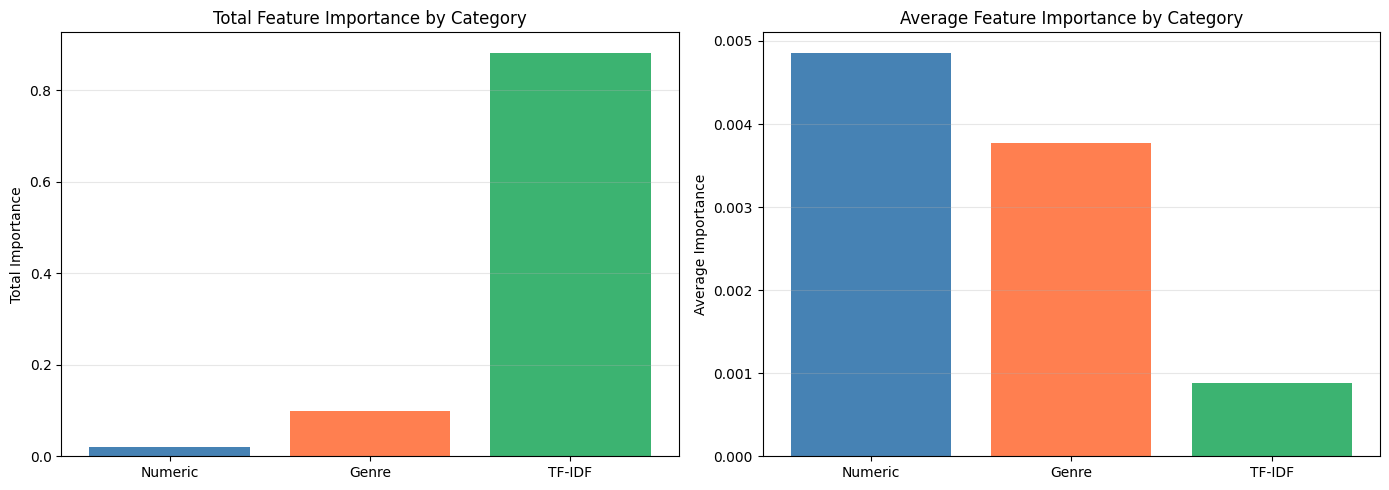


Insight: Which category (numeric, genre, or text) contributes more to predictions?


In [30]:
# Group features by category
# Identify feature types based on feature names
numeric_base = ['log_votes', 'runtime', 'director_score', 'cast_score']
genre_features = [f for f in all_feature_names if f not in numeric_base and not f.startswith('tfidf_')]
tfidf_features = [f for f in all_feature_names if f.startswith('tfidf_')]

# Calculate total importance by category
category_importance = []
for category, features in [('Numeric', numeric_base), ('Genre', genre_features), ('TF-IDF', tfidf_features)]:
    total_imp = feature_importance[feature_importance['feature'].isin(features)]['importance'].sum()
    count = len([f for f in features if f in feature_importance['feature'].values])
    category_importance.append({
        'Category': category,
        'Total Importance': total_imp,
        'Avg Importance': total_imp / count if count > 0 else 0,
        'Feature Count': count
    })

category_df = pd.DataFrame(category_importance)

print("="*60)
print("FEATURE IMPORTANCE BY CATEGORY")
print("="*60)
print(category_df.to_string(index=False))

# Visualize
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Total importance
axes[0].bar(category_df['Category'], category_df['Total Importance'], color=['steelblue', 'coral', 'mediumseagreen'])
axes[0].set_ylabel('Total Importance')
axes[0].set_title('Total Feature Importance by Category')
axes[0].grid(True, alpha=0.3, axis='y')

# Average importance
axes[1].bar(category_df['Category'], category_df['Avg Importance'], color=['steelblue', 'coral', 'mediumseagreen'])
axes[1].set_ylabel('Average Importance')
axes[1].set_title('Average Feature Importance by Category')
axes[1].grid(True, alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

print("\nInsight: Which category (numeric, genre, or text) contributes more to predictions?")


### Create Analysis DataFrame for Stratified Performance Analysis

In [31]:
# Create analysis DataFrame with predictions, errors, and key features
test_analysis = pd.DataFrame({
    'actual': y_test,
    'predicted': y_test_pred,
    'error': abs(y_test - y_test_pred),
    'votes': X_test['votes'],
    'runtime': X_test['runtime']
})

print("Analysis DataFrame created")
print(f"Shape: {test_analysis.shape}")
test_analysis.head()


Analysis DataFrame created
Shape: (7848, 5)


,actual,predicted,error,votes,runtime
53061,4.7,6.463070,1.763070,838,106
53143,6.0,6.466741,0.466741,860,90
11032,6.2,6.424099,0.224099,128,140
25327,5.7,5.706827,0.006827,1306,94
52088,6.3,5.736176,0.563824,4419,98


### Actual vs Predicted Values: Sample Inspection

Precision: Nearly 50% (48.8%) of all predictions fell within ±0.5 stars of the actual rating, and 77.6% were within ±1.0 star. Furthermore, 90.9% of predictions fell within ±1.5 stars.

Bias: The mean error remains extremely close to zero, indicating the model is unbiased on average (it doesn't systematically guess too high or too low).

Best Cases: The model achieved near-perfect predictions for several movies, with errors as low as 0.00008 (e.g., a movie with Actual 6.2 vs. Predicted 6.1999).

Worst Cases: The largest errors occurred on highly unusual films. For instance, a movie rated 1.2 was predicted to be 7.48 (Error: -6.28). This suggests the model struggles significantly with outliers—movies that have good metadata (popular cast/director) but are critically panned.

Overall: While occasional misses highlight the difficulty of predicting breakout hits or flops based solely on metadata, the fact that over 90% of errors are below 1.5 stars confirms the model's reliability for the vast majority of titles.

In [32]:
# Display sample predictions for inspection
print("="*60)
print("SAMPLE PREDICTIONS: ACTUAL VS PREDICTED")
print("="*60)

# Create detailed comparison DataFrame
comparison_df = pd.DataFrame({
    'Actual': y_test,
    'Predicted': y_test_pred,
    'Error': y_test - y_test_pred,
    'Abs_Error': abs(y_test - y_test_pred),
    'Votes': X_test['votes'],
    'Runtime': X_test['runtime']
})

print("\n1. Best Predictions (Smallest Errors):")
print("-" * 60)
best_predictions = comparison_df.nsmallest(5, 'Abs_Error')[['Actual', 'Predicted', 'Error', 'Votes', 'Runtime']]
print(best_predictions.to_string(index=False))

print("\n2. Worst Predictions (Largest Errors):")
print("-" * 60)
worst_predictions = comparison_df.nlargest(5, 'Abs_Error')[['Actual', 'Predicted', 'Error', 'Votes', 'Runtime']]
print(worst_predictions.to_string(index=False))

print("\n3. Random Sample (10 movies):")
print("-" * 60)
random_sample = comparison_df.sample(10, random_state=42)[['Actual', 'Predicted', 'Error', 'Votes', 'Runtime']]
print(random_sample.to_string(index=False))

# Summary statistics
print("\n" + "="*60)
print("PREDICTION ERROR STATISTICS")
print("="*60)
print(f"Mean Error (Bias):           {comparison_df['Error'].mean():.4f}")
print(f"Mean Absolute Error:         {comparison_df['Abs_Error'].mean():.4f}")
print(f"Median Absolute Error:       {comparison_df['Abs_Error'].median():.4f}")
print(f"Max Overestimation:          {comparison_df['Error'].max():.4f} (predicted too high)")
print(f"Max Underestimation:         {comparison_df['Error'].min():.4f} (predicted too low)")
print(f"\nPredictions within ±0.5:     {(comparison_df['Abs_Error'] <= 0.5).sum()} ({(comparison_df['Abs_Error'] <= 0.5).sum()/len(comparison_df)*100:.1f}%)")
print(f"Predictions within ±1.0:     {(comparison_df['Abs_Error'] <= 1.0).sum()} ({(comparison_df['Abs_Error'] <= 1.0).sum()/len(comparison_df)*100:.1f}%)")
print(f"Predictions within ±1.5:     {(comparison_df['Abs_Error'] <= 1.5).sum()} ({(comparison_df['Abs_Error'] <= 1.5).sum()/len(comparison_df)*100:.1f}%)")


SAMPLE PREDICTIONS: ACTUAL VS PREDICTED

1. Best Predictions (Smallest Errors):
------------------------------------------------------------
 Actual  Predicted     Error  Votes  Runtime
    6.2   6.199916  0.000084    107       67
    6.6   6.600369 -0.000369   5142       98
    7.5   7.500427 -0.000427  15532       96
    5.8   5.799556  0.000444    454       90
    4.6   4.599549  0.000451    466       93

2. Worst Predictions (Largest Errors):
------------------------------------------------------------
 Actual  Predicted     Error  Votes  Runtime
    1.2   7.482809 -6.282809  96369      133
    1.5   7.120316 -5.620316    150       61
    1.8   7.166836 -5.366836   3883       90
    2.1   7.118101 -5.018101    372       97
    1.8   6.664285 -4.864285   1007       92

3. Random Sample (10 movies):
------------------------------------------------------------
 Actual  Predicted     Error  Votes  Runtime
    6.8   6.456136  0.343864   3309      103
    5.9   6.073141 -0.173141    214 

### Performance by Strata: Runtime Categories

PERFORMANCE BY RUNTIME CATEGORIES
                     Mean Error (MAE)  Std Error  Count
runtime_category                                       
Short (≤90min)                 0.7054     0.6419   3043
Medium (90-120min)             0.6479     0.5783   3769
Long (120-150min)              0.7324     0.6987    696
Very Long (>150min)            0.7587     0.6687    340


C:\Users\anilo\AppData\Local\Temp\ipykernel_30204\2343223343.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  runtime_stats = test_analysis.groupby('runtime_category').agg({
C:\Users\anilo\AppData\Local\Temp\ipykernel_30204\2343223343.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  runtime_means = test_analysis.groupby('runtime_category')['error'].mean()
C:\Users\anilo\AppData\Local\Temp\ipykernel_30204\2343223343.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True 

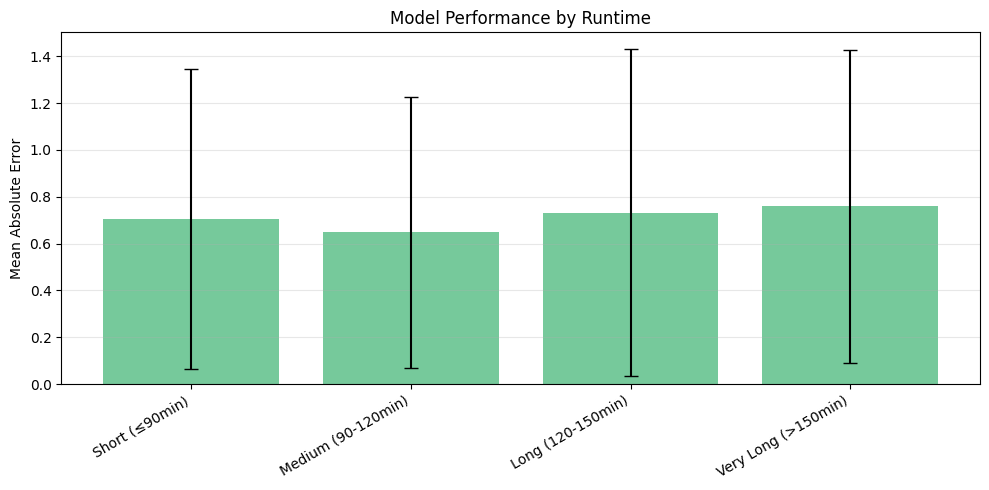


Insight: Does runtime affect prediction accuracy?


In [33]:
# Categorize by runtime
test_analysis['runtime_category'] = pd.cut(
    test_analysis['runtime'], 
    bins=[0, 90, 120, 150, float('inf')],
    labels=['Short (≤90min)', 'Medium (90-120min)', 'Long (120-150min)', 'Very Long (>150min)']
)

print("="*60)
print("PERFORMANCE BY RUNTIME CATEGORIES")
print("="*60)

runtime_stats = test_analysis.groupby('runtime_category').agg({
    'error': ['mean', 'std', 'count']
}).round(4)
runtime_stats.columns = ['Mean Error (MAE)', 'Std Error', 'Count']
print(runtime_stats)

# Visualize
plt.figure(figsize=(10, 5))
runtime_means = test_analysis.groupby('runtime_category')['error'].mean()
runtime_stds = test_analysis.groupby('runtime_category')['error'].std()

plt.bar(range(len(runtime_means)), runtime_means.values, yerr=runtime_stds.values,
        capsize=5, alpha=0.7, color='mediumseagreen')
plt.xticks(range(len(runtime_means)), runtime_means.index, rotation=30, ha='right')
plt.ylabel('Mean Absolute Error')
plt.title('Model Performance by Runtime')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\nInsight: Does runtime affect prediction accuracy?")

### Performance by Strata: Rating Ranges

PERFORMANCE BY RATING RANGES
                 Mean Error (MAE)  Std Error  Count
rating_category                                    
Poor (≤5)                  1.0200     0.8369   1777
Below Avg (5-6)            0.5341     0.3898   1960
Average (6-7)              0.4856     0.4157   2597
Good (7-8)                 0.6906     0.5286   1290
Excellent (>8)             1.5399     0.8271    224


C:\Users\anilo\AppData\Local\Temp\ipykernel_30204\3847772845.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rating_stats = test_analysis.groupby('rating_category').agg({
C:\Users\anilo\AppData\Local\Temp\ipykernel_30204\3847772845.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  rating_means = test_analysis.groupby('rating_category')['error'].mean()
C:\Users\anilo\AppData\Local\Temp\ipykernel_30204\3847772845.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to a

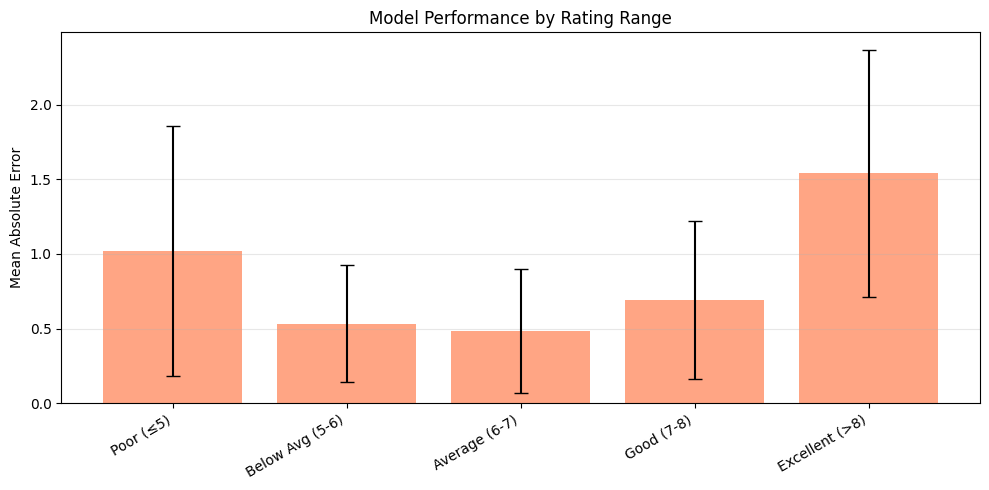


Insight: Does model struggle more with extreme ratings (very low/high)?


In [34]:
# Categorize by actual rating ranges
test_analysis['rating_category'] = pd.cut(
    test_analysis['actual'], 
    bins=[0, 5, 6, 7, 8, 10],
    labels=['Poor (≤5)', 'Below Avg (5-6)', 'Average (6-7)', 'Good (7-8)', 'Excellent (>8)']
)

print("="*60)
print("PERFORMANCE BY RATING RANGES")
print("="*60)

rating_stats = test_analysis.groupby('rating_category').agg({
    'error': ['mean', 'std', 'count']
}).round(4)
rating_stats.columns = ['Mean Error (MAE)', 'Std Error', 'Count']
print(rating_stats)

# Visualize
plt.figure(figsize=(10, 5))
rating_means = test_analysis.groupby('rating_category')['error'].mean()
rating_stds = test_analysis.groupby('rating_category')['error'].std()

plt.bar(range(len(rating_means)), rating_means.values, yerr=rating_stds.values,
        capsize=5, alpha=0.7, color='coral')
plt.xticks(range(len(rating_means)), rating_means.index, rotation=30, ha='right')
plt.ylabel('Mean Absolute Error')
plt.title('Model Performance by Rating Range')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\nInsight: Does model struggle more with extreme ratings (very low/high)?")

### Performance by Strata: Vote Categories

PERFORMANCE BY VOTE CATEGORIES (Popularity)
                  Mean Error (MAE)  Std Error  Count
vote_category                                       
Low (≤500)                  0.7280     0.6507   2667
Medium (501-2K)             0.6860     0.6150   2665
High (2K-10K)               0.6475     0.5866   1806
Very High (>10K)            0.5878     0.5848    710


C:\Users\anilo\AppData\Local\Temp\ipykernel_30204\3872794000.py:12: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  vote_stats = test_analysis.groupby('vote_category').agg({
C:\Users\anilo\AppData\Local\Temp\ipykernel_30204\3872794000.py:20: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  vote_means = test_analysis.groupby('vote_category')['error'].mean()
C:\Users\anilo\AppData\Local\Temp\ipykernel_30204\3872794000.py:21: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the

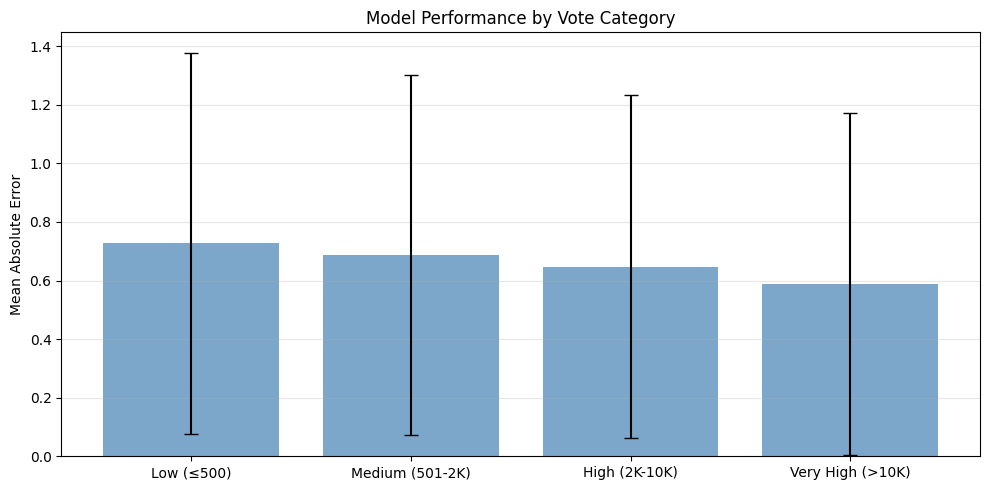


Insight: Does model perform better on popular vs unpopular movies?


In [35]:
# Categorize by vote counts (popularity)
test_analysis['vote_category'] = pd.cut(
    test_analysis['votes'], 
    bins=[0, 500, 2000, 10000, float('inf')],
    labels=['Low (≤500)', 'Medium (501-2K)', 'High (2K-10K)', 'Very High (>10K)']
)

print("="*60)
print("PERFORMANCE BY VOTE CATEGORIES (Popularity)")
print("="*60)

vote_stats = test_analysis.groupby('vote_category').agg({
    'error': ['mean', 'std', 'count']
}).round(4)
vote_stats.columns = ['Mean Error (MAE)', 'Std Error', 'Count']
print(vote_stats)

# Visualize
plt.figure(figsize=(10, 5))
vote_means = test_analysis.groupby('vote_category')['error'].mean()
vote_stds = test_analysis.groupby('vote_category')['error'].std()

plt.bar(range(len(vote_means)), vote_means.values, yerr=vote_stds.values, 
        capsize=5, alpha=0.7, color='steelblue')
plt.xticks(range(len(vote_means)), vote_means.index, rotation=0)
plt.ylabel('Mean Absolute Error')
plt.title('Model Performance by Vote Category')
plt.grid(True, alpha=0.3, axis='y')
plt.tight_layout()
plt.show()

print("\nInsight: Does model perform better on popular vs unpopular movies?")

## Actual vs Predicted 

-The plot shows a clustering around zero, but with some distinct patterns. Specifically, for lower predicted ratings, the residuals tend to be positive (under-prediction), while for higher ratings, they can be negative. This confirms the "High Bias" diagnosis—the model is conservative and avoids predicting extreme low/high scores. (left)

-The model is reliable for "average" movies (rated 5-8) but loses accuracy for masterpieces or disasters. It tends to "compress" predictions towards the mean (e.g., predicting a 6.0 for a movie actually rated 2.0). (Right)

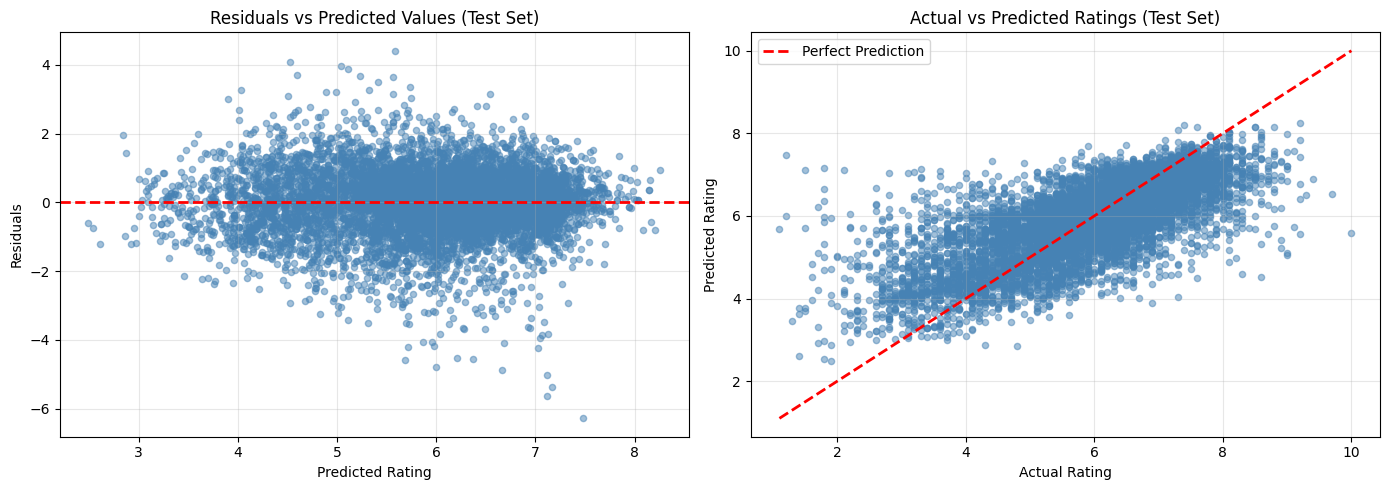

Good model: Residuals randomly scattered around 0 (no pattern)
Good model: Points close to diagonal line in Actual vs Predicted


In [36]:
# Residuals vs Predicted Values and Actual vs Predicted
fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Residuals vs Predicted
axes[0].scatter(y_test_pred, test_residuals, alpha=0.5, s=20, color='steelblue')
axes[0].axhline(0, color='red', linestyle='--', linewidth=2)
axes[0].set_xlabel('Predicted Rating')
axes[0].set_ylabel('Residuals')
axes[0].set_title('Residuals vs Predicted Values (Test Set)')
axes[0].grid(True, alpha=0.3)

# Actual vs Predicted
axes[1].scatter(y_test, y_test_pred, alpha=0.5, s=20, color='steelblue')
axes[1].plot([y_test.min(), y_test.max()], [y_test.min(), y_test.max()], 
             'r--', linewidth=2, label='Perfect Prediction')
axes[1].set_xlabel('Actual Rating')
axes[1].set_ylabel('Predicted Rating')
axes[1].set_title('Actual vs Predicted Ratings (Test Set)')
axes[1].legend()
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("Good model: Residuals randomly scattered around 0 (no pattern)")
print("Good model: Points close to diagonal line in Actual vs Predicted")

### Residual Analysis: Q-Q Plot

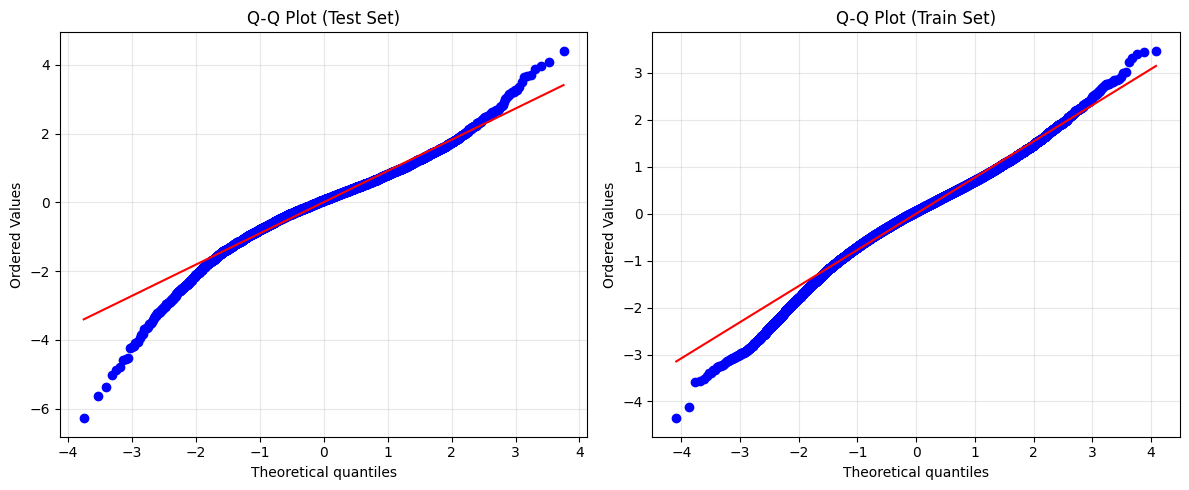

If points follow the diagonal line → residuals are normally distributed
Deviations at tails → heavy-tailed distribution (common in real data)


In [37]:
# Q-Q Plot to check if residuals are normally distributed
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
stats.probplot(test_residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot (Test Set)')
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
stats.probplot(train_residuals, dist="norm", plot=plt)
plt.title('Q-Q Plot (Train Set)')
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("If points follow the diagonal line → residuals are normally distributed")
print("Deviations at tails → heavy-tailed distribution (common in real data)")

### Residual Analysis: Error Histogram

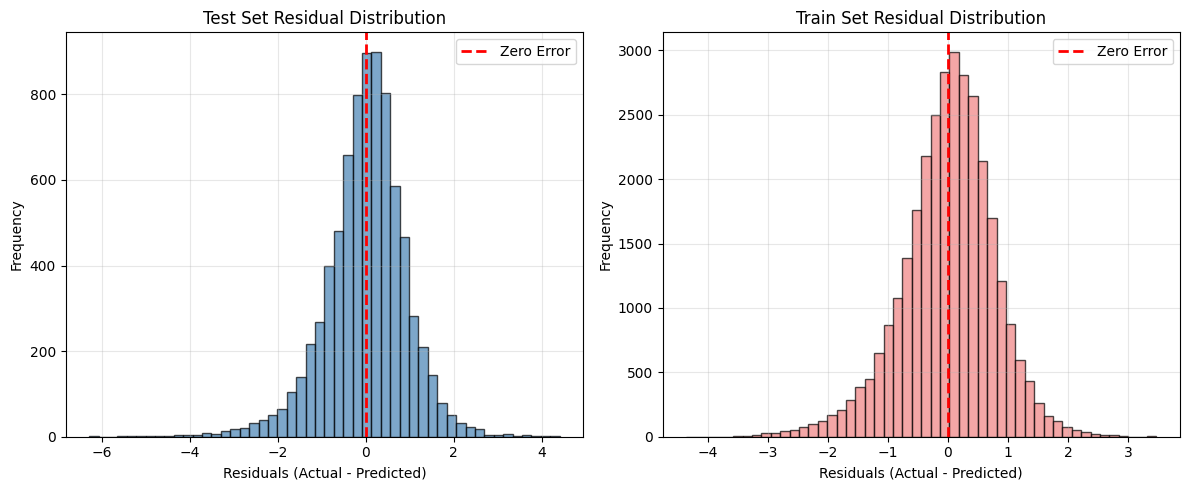


Residual Statistics:
Test:  Min=-6.283, Max=4.411, Median=0.063
Train: Min=-4.359, Max=3.471, Median=0.050


In [38]:
# Error Histogram
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.hist(test_residuals, bins=50, edgecolor='black', alpha=0.7, color='steelblue')
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Test Set Residual Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.subplot(1, 2, 2)
plt.hist(train_residuals, bins=50, edgecolor='black', alpha=0.7, color='lightcoral')
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')
plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Frequency')
plt.title('Train Set Residual Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print("\nResidual Statistics:")
print(f"Test:  Min={test_residuals.min():.3f}, Max={test_residuals.max():.3f}, Median={test_residuals.median():.3f}")
print(f"Train: Min={train_residuals.min():.3f}, Max={train_residuals.max():.3f}, Median={train_residuals.median():.3f}")

## Error Distribution

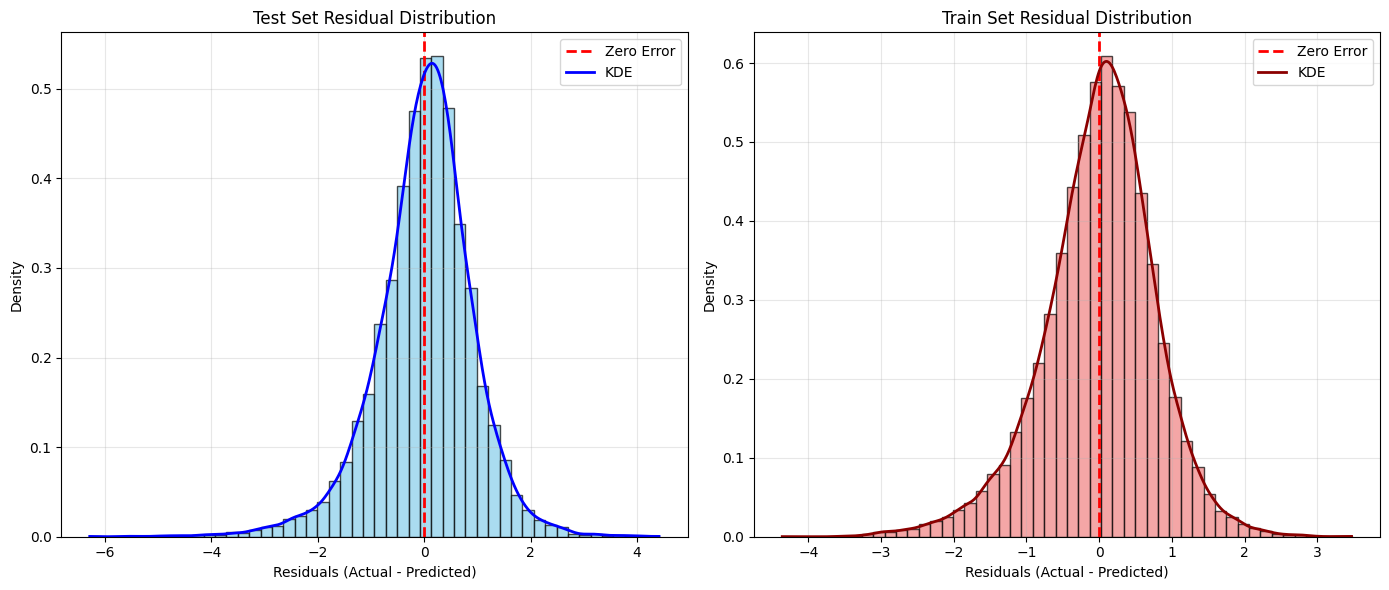


Residual Distribution Statistics:
Test Set: Skewness=-0.5453, Kurtosis=2.5355
Train Set: Skewness=-0.4180, Kurtosis=1.1686


In [39]:
# Create a figure with two subplots
plt.figure(figsize=(14, 6))

# Subplot 1: Test Set Residuals
plt.subplot(1, 2, 1)
plt.hist(test_residuals, bins=50, edgecolor='black', alpha=0.7, color='skyblue', density=True)
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')

# Add Kernel Density Estimate (KDE) line for Test
kde_test = stats.gaussian_kde(test_residuals)
x_range_test = np.linspace(test_residuals.min(), test_residuals.max(), 500)
plt.plot(x_range_test, kde_test(x_range_test), color='blue', linewidth=2, label='KDE')

plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Density')
plt.title('Test Set Residual Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

# Subplot 2: Train Set Residuals
plt.subplot(1, 2, 2)
plt.hist(train_residuals, bins=50, edgecolor='black', alpha=0.7, color='lightcoral', density=True)
plt.axvline(0, color='red', linestyle='--', linewidth=2, label='Zero Error')

# Add KDE line for Train
kde_train = stats.gaussian_kde(train_residuals)
x_range_train = np.linspace(train_residuals.min(), train_residuals.max(), 500)
plt.plot(x_range_train, kde_train(x_range_train), color='darkred', linewidth=2, label='KDE')

plt.xlabel('Residuals (Actual - Predicted)')
plt.ylabel('Density')
plt.title('Train Set Residual Distribution')
plt.legend()
plt.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Print Distribution Statistics
print("\nResidual Distribution Statistics:")
print(f"Test Set: Skewness={stats.skew(test_residuals):.4f}, Kurtosis={stats.kurtosis(test_residuals):.4f}")
print(f"Train Set: Skewness={stats.skew(train_residuals):.4f}, Kurtosis={stats.kurtosis(train_residuals):.4f}")